In [1]:
import simdna
import simdna.synthetic as synthetic
import avutils
from avutils import util
reload(util)
import numpy as np
import momma_dragonn
reload(momma_dragonn)
import keras

In [2]:
def generate_sequences_set(seq_length, num_seqs, motif_names):
    loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
    embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(seqLength=seq_length)
        , embedders=[
            synthetic.RepeatedEmbedder(
            synthetic.SubstringEmbedder(
                #synthetic.ReverseComplementWrapper(
                substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(
                    loadedMotifs=loadedMotifs,motifName=motifName)
                #),
                ,positionGenerator=synthetic.UniformPositionGenerator()),
            quantityGenerator=
                synthetic.ZeroInflater(
                    #synthetic.MinMaxWrapper(synthetic.PoissonQuantityGenerator(1),theMax=1, theMin=0),
                    synthetic.FixedQuantityGenerator(1),
                    zeroProb=0.9)
            )
            for motifName in motif_names
        ]
    )
    sequenceSetGenerator = synthetic.GenerateSequenceNTimes(embedInBackground, num_seqs)
    return sequenceSetGenerator

def one_hot_encode_sequences_set(sequence_set_generator):
    one_hot_encoded_sequences = []
    for sequence in sequence_set_generator.generateSequences():
        one_hot_encoded_sequences.append(avutils.util.seq_to_2d_image(sequence.seq))
    return np.array(one_hot_encoded_sequences)

seq_length=45


motif_names = ["CTCF_known1"]#, "IRF_known1", "GATA_disc1"]

num_train_samples = 20000

one_hot_data_train_pos, one_hot_data_train_neg =\
 [one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_train_samples, motif_names=names))
  for names in [motif_names, []]]
one_hot_data_train_inputs = np.concatenate([one_hot_data_train_pos, one_hot_data_train_neg], axis=0)
one_hot_data_train_labels = np.concatenate([np.ones((len(one_hot_data_train_pos),1)), np.zeros((len(one_hot_data_train_neg),1))], axis=0)
_ = util.shuffle_arrays([one_hot_data_train_inputs, one_hot_data_train_labels], copy_on_shuffle=True)


In [3]:
reload(util)
one_hot_data_valid_pos, one_hot_data_valid_neg =\
 [one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=1000, motif_names=names))
  for names in [motif_names, []]]
one_hot_data_valid_inputs = np.concatenate([one_hot_data_valid_pos, one_hot_data_valid_neg], axis=0)
one_hot_data_valid_labels = np.concatenate([np.ones((len(one_hot_data_valid_pos),1)), np.zeros((len(one_hot_data_valid_neg),1))], axis=0)
_ = util.shuffle_arrays([one_hot_data_valid_inputs, one_hot_data_valid_labels], copy_on_shuffle=True)

In [4]:
import keras
reload(keras)
import keras.objectives
reload(keras.objectives)
from keras import backend
reload(backend)
import keras.layers.convolutional
reload(keras.layers.convolutional)
import momma_dragonn
reload(momma_dragonn)
reload(momma_dragonn.end_of_epoch_callbacks)
reload(momma_dragonn.data_loaders)
reload(momma_dragonn.model_evaluators)
reload(momma_dragonn.model_trainers.keras_model_trainer)
reload(momma_dragonn.data_loaders.core)

def model_creator_func(nb_filter, activation):
    filter_width=20
    maxpool_filter_width=seq_length-(filter_width-1) #pool over entire region for now
    #maxpool_filter_width=20
    
    from keras.models import Graph
    graph = Graph() 
    graph.add_input(name="sequence", input_shape=(1,4,seq_length))
    #add convolutional layer
    graph.add_node(
        keras.layers.convolutional.Convolution2D(nb_filter=nb_filter, nb_row=4, nb_col=filter_width,
                                                 activation=activation, W_regularizer=keras.regularizers.WeightRegularizer(l1=0.00001)),
        name="conv", input="sequence")
    #add maxpool filter layer
    graph.add_node(
        keras.layers.convolutional.MaxPooling2D(pool_size=(1,maxpool_filter_width),
                                                strides=(1,1), border_mode="valid"),
        name="pool", input="conv")
    #flatten
    graph.add_node(
        keras.layers.core.Flatten(),
        name="flatten", input="pool")
    #add output neuron
    graph.add_node(
        keras.layers.core.Dense(1,activation="sigmoid"),
        name="output_sigmoid", input="flatten")
    #designate output node
    graph.add_output(name="output", input="output_sigmoid")
    #compile
    graph.compile(
        optimizer=keras.optimizers.Adam(),
        loss={"output": "binary_crossentropy"}
    )
    return graph

#data loaders
train_data_loader = momma_dragonn.data_loaders.core.BatchDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_train_inputs}, Y={'output': one_hot_data_train_labels},
                        weight={}, batch_size=200, num_to_load_for_eval=num_train_samples, bundle_x_and_y_in_generator=True)
valid_data_loader = momma_dragonn.data_loaders.core.AtOnceDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_valid_inputs}, Y={'output': one_hot_data_valid_labels})
#model evaluator
model_evaluator = momma_dragonn.model_evaluators.GraphAccuracyStats(
    key_metric="auROC", all_metrics=["auROC"])

#stopping criterion
stopping_criterion_config = {"class": "EarlyStopping", "kwargs": {"max_epochs": 300, "epochs_to_wait": 10}}

#callbacks
end_of_epoch_callbacks = []#momma_dragonn.end_of_epoch_callbacks.PrintPerfAfterEpoch(print_trend=True)]

#trainer
trainer = momma_dragonn.model_trainers.keras_model_trainer.KerasFitGeneratorModelTrainer(
    samples_per_epoch=num_train_samples, stopping_criterion_config=stopping_criterion_config)

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
Using Theano backend.


('Input modes', ['sequence'])
('Output modes', ['output'])


In [5]:
#model creator
filters_per_motif=1
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names), activation="relu"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    

#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.7118 - val_loss: 0.6921
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6922 - val_loss: 0.6904
Epoch 1/1
20000/20000 [==============================] - 0s - loss: 0.6900 - val_loss: 0.6877
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6865 - val_loss: 0.6844
Epoch 1/1
20000/20000 [==============================] - 0s - loss: 0.6822 - val_loss: 0.6816
Epoch 1/1
20000/20000 [==============================] - 0s - loss: 0.6793 - val_loss: 0.6798
Epoch 1/1
20000/20000 [==============================] - 0s - loss: 0.6757 - val_loss: 0.6786
Epoch 1/1
20000/20000 [==============================] - 0s - loss: 0.6747 - val_loss: 0.6777
Epoch 1/1
20000/20000 [==============================] - 0s - loss: 0.6723 - val_loss: 0.6768
Epoch 1/1
20000/20000 [==============================] - 

In [6]:
file_prefix="solofilter_10pcCTCF_45bp_feedforward_relu"

In [7]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

In [8]:
%matplotlib inline
#import deepLIFT stuff
import os, sys
import numpy as np
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
reload(deepLIFTutils)

def sortAndPrintFilters(weights,biases):
    filterScores = np.sum((np.max(weights,axis=-2)-np.min(weights,axis=-2)),axis=-1)[:,0]
    sortedFilters = sorted(enumerate(filterScores), key=lambda x: -x[1])
    deepLIFTutils.plotPositiveAndNegativeOutlierFilters(sortedFilters=sortedFilters
                                                        , numPositiveOutliers=len(weights)
                                                        , numNegativeOutliers=0
                                                        , weights=weights
                                                        , biases=np.zeros(len(weights))
                                                        , printBias=False
                                                        , figSize=(10,2))

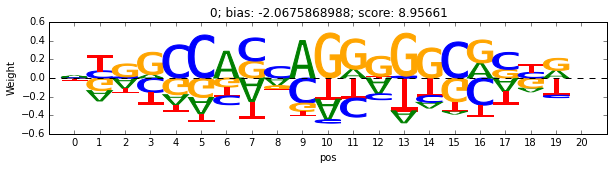

In [9]:
weights, biases = model.nodes['conv'].get_weights()
sortAndPrintFilters(weights, biases)

In [15]:
#model creator
filters_per_motif=20
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names), activation="relu"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    

#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.7351 - val_loss: 0.7038
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.7039 - val_loss: 0.6994
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6969 - val_loss: 0.6962
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6944 - val_loss: 0.6941
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6886 - val_loss: 0.6927
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6863 - val_loss: 0.6919
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6840 - val_loss: 0.6906
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6807 - val_loss: 0.6902
Epoch 1/1
20000/20000 [==============================] - 1s - loss: 0.6792 - val_loss: 0.6893
Epoch 1/1
20000/20000 [==============================] - 

In [11]:
file_prefix="20filter_10pcCTCF_45bp_feedforward_relu"

In [ ]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [12]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

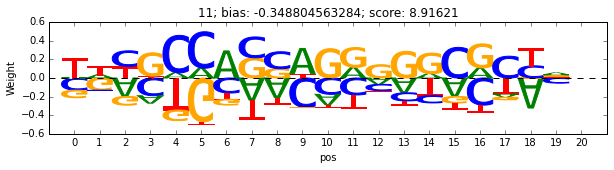

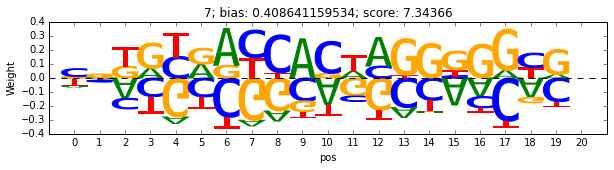

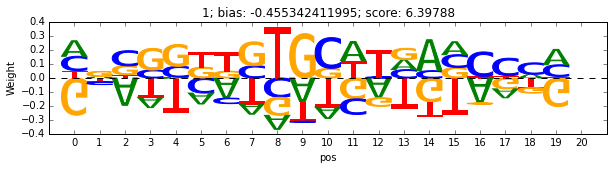

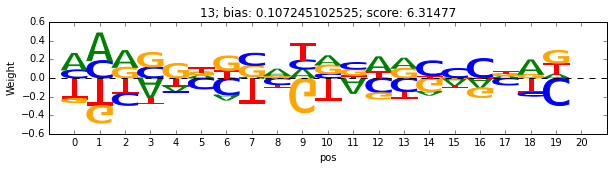

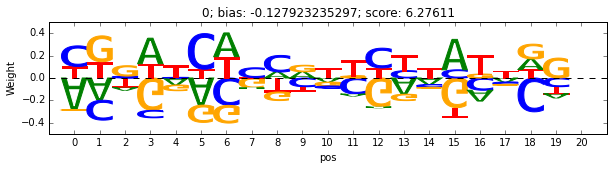

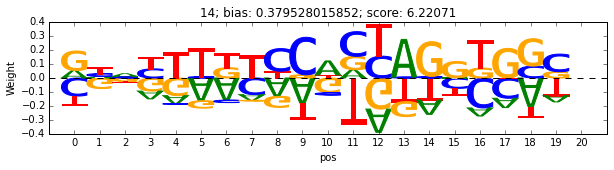

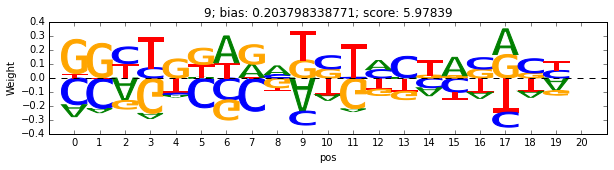

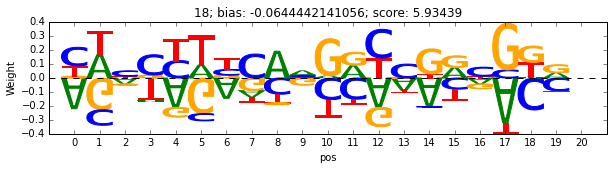

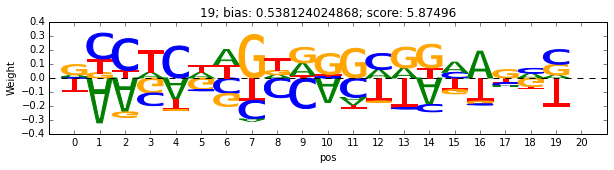

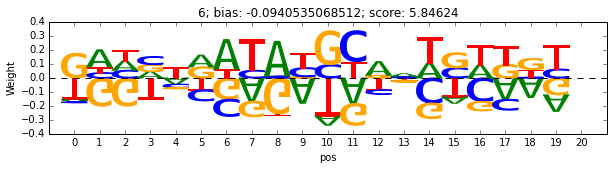

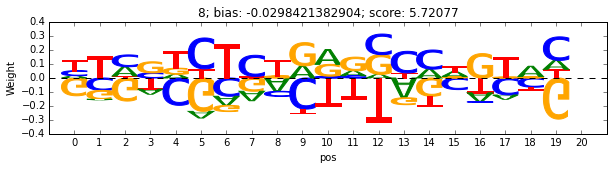

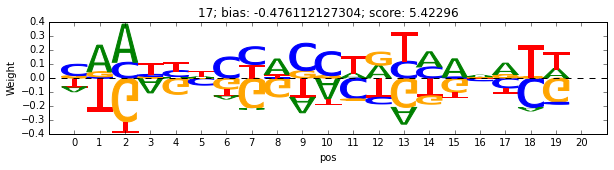

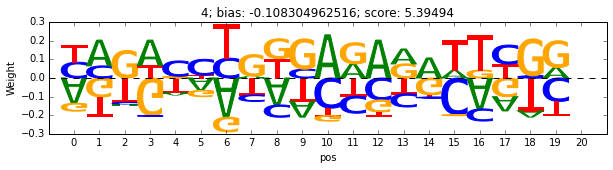

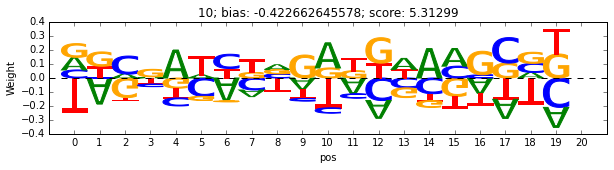

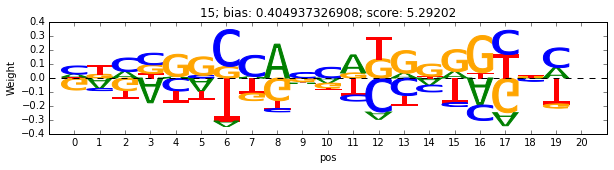

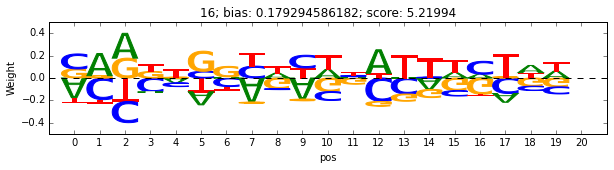

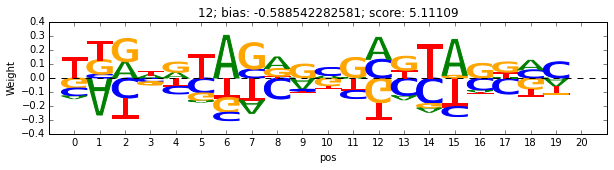

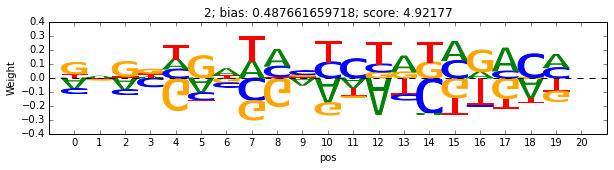

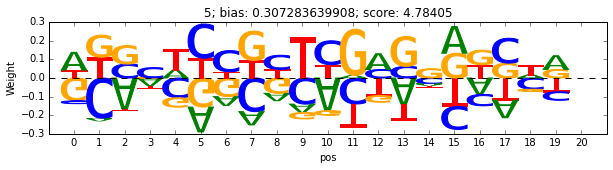

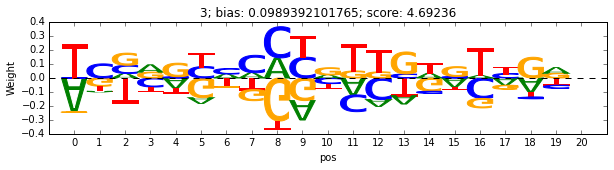

In [16]:
weights, biases = model.nodes['conv'].get_weights()
sortAndPrintFilters(weights, biases)

In [ ]:
#model creator
filters_per_motif=20
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names), activation="sigmoid"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    

#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

In [ ]:
file_prefix="solofilter_10pcCTCF_45bp_feedforward_sigmoid"

In [ ]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

In [ ]:
weights, biases = model.nodes['conv'].get_weights()
sortAndPrintFilters(weights, biases)